In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/melanoma_images/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/melanoma_images/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
num_classes = 9
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True, seed=123,
    validation_split=None, subset=None, interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True, seed=123,
    validation_split=None, subset=None, interpolation='bilinear', follow_links=False
)

Found 118 files belonging to 9 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

NameError: ignored

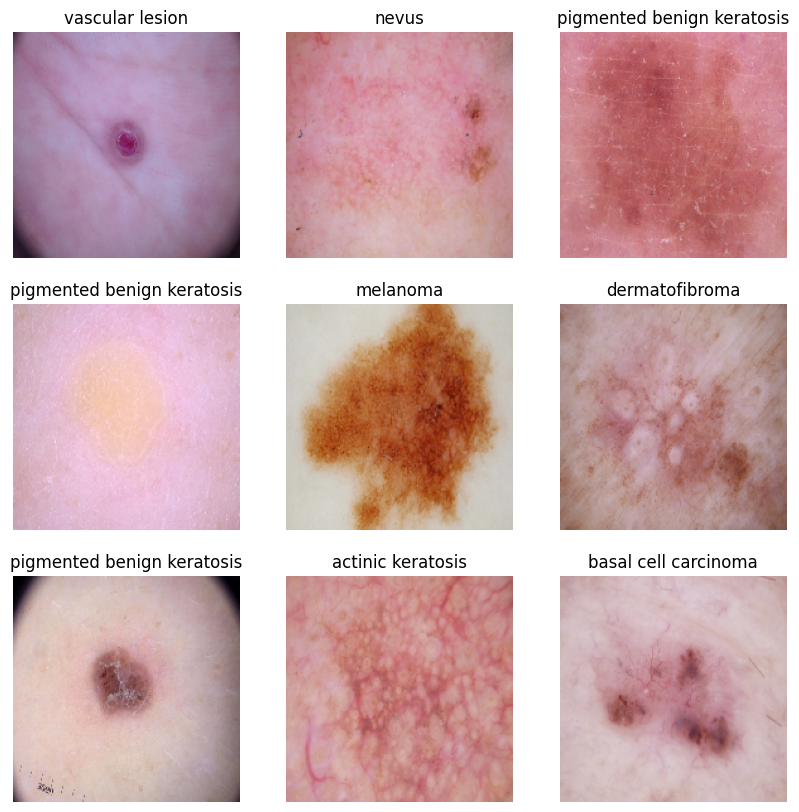

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch)
#   break

In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


In [ ]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 70s 986ms/step - loss: 4.7453 - accuracy: 0.0831 - val_loss: 6.7975 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 68s 969ms/step - loss: 4.6675 - accuracy: 0.0808 - val_loss: 6.7924 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 70s 994ms/step - loss: 4.6694 - accuracy: 0.0808 - val_loss: 6.7990 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 69s 991ms/step - loss: 4.6689 - accuracy: 0.0808 - val_loss: 6.7990 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 69s 984ms/step - loss: 4.6689 - accuracy: 0.0808 - val_loss: 6.7990 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 67s 952ms/step - loss: 4.6689 - accuracy: 0.0808 - val_loss: 6.7990 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 69s 993ms/step - loss: 4.6689 - accuracy: 0.0808 - val_loss: 6.7990 - val_accuracy: 0.1356

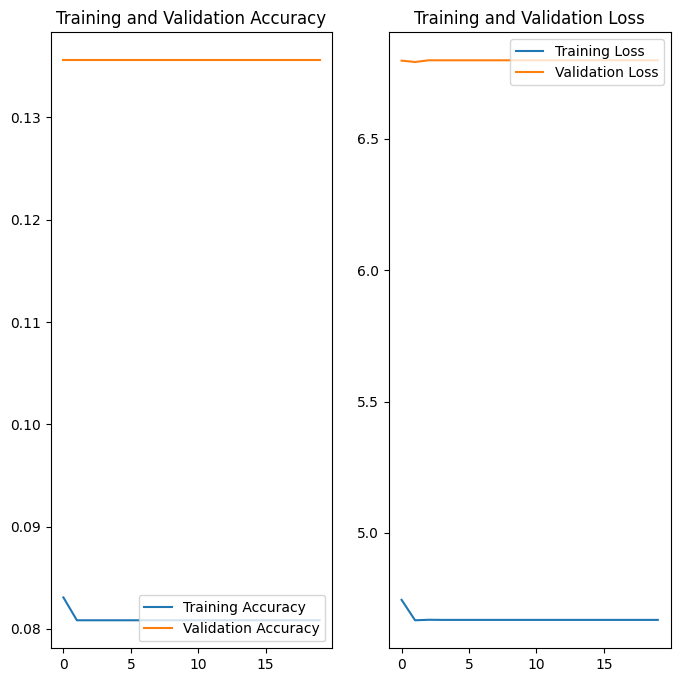

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1.   As per the Graph there is a huge diffrence between the Training and Testing Accuracy which clearly a sign of **Overfitting**.

2.   In both Accuaracy and Validation graph it shows a overall linearly constant nature over time.



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

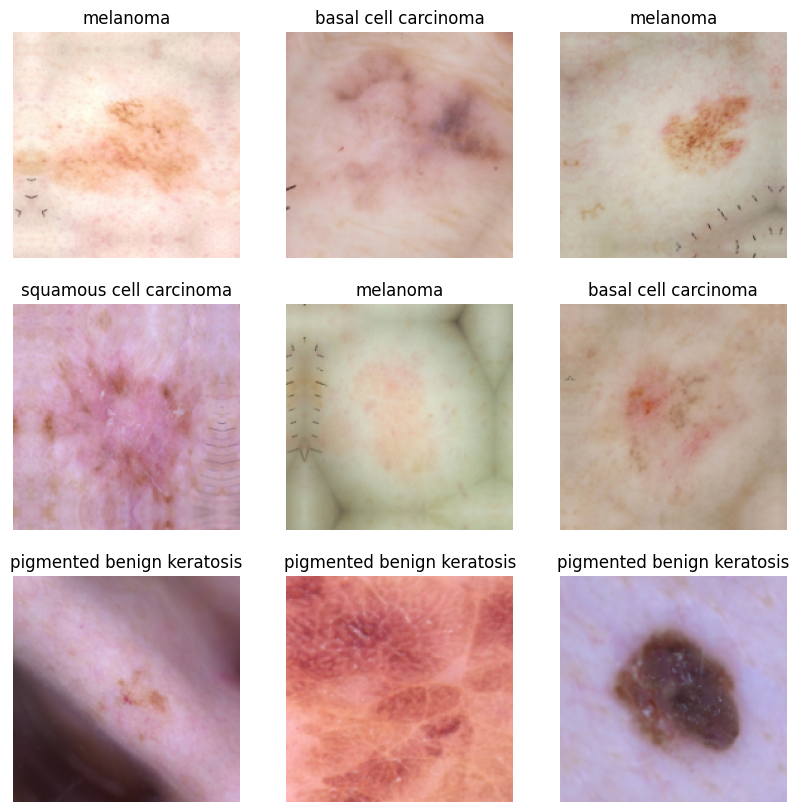

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 114s 2s/step - loss: 13.1971 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 83s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 84s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 84s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 82s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 83s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 82s 1s/step - loss: 13.4113 - accuracy: 0.1679 - val_loss: 13.9326 - val_accuracy: 0.1356
Epoch

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the training and validation accuracy
fig1 = make_subplots()
fig1.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'], name='Training Accuracy'))
fig1.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'], name='Validation Accuracy'))
fig1.update_layout(title='Training and Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig1.show()

# Plot the training and validation loss
fig2 = make_subplots()
fig2.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['loss'], name='Training Loss'))
fig2.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_loss'], name='Validation Loss'))
fig2.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig2.show()


1.   After Augmantation the diffrence between the Training and testing accuarcy is dicreased but the accuracy is very low and the diffrence is still little high so model is not performing well.

2.   In both Accuaracy and Validation graph it shows a overall linearly constant nature over time.



Let's check the **Total Class Distribution** in the dataset.

In [ ]:
import os

root_path = r"/content/gdrive/MyDrive/melanoma_images/Train/"
num_images = 0

# Iterate over each subdirectory
for dirpath, dirnames, filenames in os.walk(root_path):
    # Count the number of image files in the current subdirectory
    for filename in filenames:
        if filename.lower().endswith(('.jpg')):
            num_images += 1

    dir_class_name = dirpath.split("/")[-1]
    # print(dir_class_name)

    # Print the number of image files in the current subdirectory
    if num_images != 0:
      print(f"Found {num_images} images in Class: {dir_class_name}")
    num_images = 0



Found 114 images in Class: actinic keratosis
Found 376 images in Class: basal cell carcinoma
Found 462 images in Class: pigmented benign keratosis
Found 95 images in Class: dermatofibroma
Found 438 images in Class: melanoma
Found 357 images in Class: nevus
Found 139 images in Class: vascular lesion
Found 181 images in Class: squamous cell carcinoma
Found 77 images in Class: seborrheic keratosis


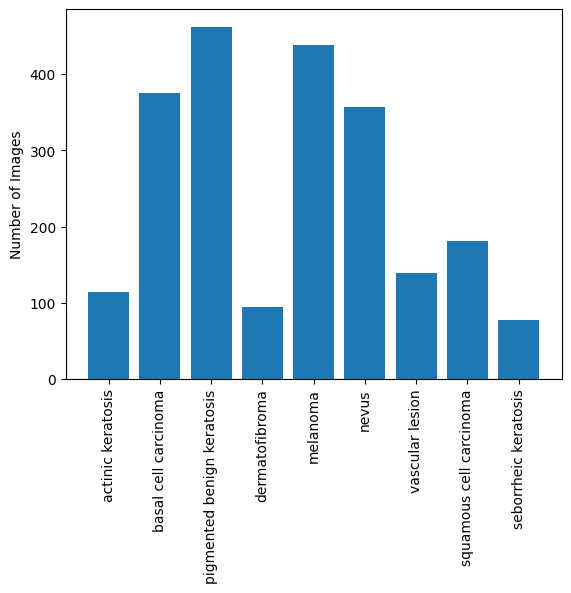

In [ ]:
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
# print(subdirectories)

main_class_name = [name.split("/")[-1] for name in subdirectories]
# print(main_class_name)

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(main_class_name, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

1. Which class has the least number of samples?
 - As per the count of images of each class we clearly say that **seborrheic keratosis** has the least number of images.

2. Which classes dominate the data in terms proportionate number of samples?
  - **pigmented benign keratosis, melanoma, basal cell carcinoma and nevus** this four classes are dominate the data as they cover 70% of the data in terms of number of samples.

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

path_to_training_dataset="/content/gdrive/MyDrive/melanoma_images/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B7562367DF0>: 100%|██████████| 500/500 [00:30<00:00, 16.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7563C17790>: 100%|██████████| 500/500 [00:29<00:00, 17.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7563D837C0>: 100%|██████████| 500/500 [00:31<00:00, 15.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7B75619F3E80>: 100%|██████████| 500/500 [02:03<00:00,  4.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B7563C17790>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7561A07BB0>: 100%|██████████| 500/500 [00:22<00:00, 21.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B7561A4E2F0>: 100%|██████████| 500/500 [00:46<00:00, 10.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B75623A3AC0>: 100%|██████████| 500/500 [00:20<00:00, 23.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B75622F83A0>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
import glob

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(set(lesion_list_new))

{'seborrheic keratosis', 'actinic keratosis', 'squamous cell carcinoma', 'melanoma', 'basal cell carcinoma', 'dermatofibroma', 'pigmented benign keratosis', 'nevus', 'vascular lesion'}


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
pigmented benign keratosis    500
dermatofibroma                500
melanoma                      500
nevus                         500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
Name: Label, dtype: int64

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train= pathlib.Path("/content/gdrive/MyDrive/melanoma_images/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 210s 1s/step - loss: 1.9937 - accuracy: 0.2502 - val_loss: 1.5370 - val_accuracy: 0.4848
Epoch 2/20
169/169 [==============================] - 211s 1s/step - loss: 1.4637 - accuracy: 0.4420 - val_loss: 1.2865 - val_accuracy: 0.5241
Epoch 3/20
169/169 [==============================] - 207s 1s/step - loss: 1.2186 - accuracy: 0.5428 - val_loss: 1.2249 - val_accuracy: 0.5249
Epoch 4/20
169/169 [==============================] - 210s 1s/step - loss: 1.0883 - accuracy: 0.5968 - val_loss: 1.2387 - val_accuracy: 0.5575
Epoch 5/20
169/169 [==============================] - 210s 1s/step - loss: 0.8900 - accuracy: 0.6704 - val_loss: 1.0765 - val_accuracy: 0.6088
Epoch 6/20
169/169 [==============================] - 213s 1s/step - loss: 0.7214 - accuracy: 0.7420 - val_loss: 0.8561 - val_accuracy: 0.7216
Epoch 7/20
169/169 [==============================] - 210s 1s/step - loss: 0.6106 - accuracy: 0.7774 - val_loss: 1.0066 - val_accuracy: 0.6726

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the training and validation accuracy
fig1 = make_subplots()
fig1.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'], name='Training Accuracy'))
fig1.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'], name='Validation Accuracy'))
fig1.update_layout(title='Training and Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig1.show()

# Plot the training and validation loss
fig2 = make_subplots()
fig2.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['loss'], name='Training Loss'))
fig2.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_loss'], name='Validation Loss'))
fig2.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig2.show()

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
# load the image
img = Image.open("/content/gdrive/MyDrive/ISIC_0000003.jpg")

# datagen = ImageDataGenerator(rescale=1.0/255.0)
# # resize the image
img = img.resize((180, 180 ))
img = np.reshape(img,[180,180,3])

# convert to numpy array and normalize
img_array = np.array(img)
img_tensor = img_array.astype('float32')
img_tensor /= 255.
img_tensor = np.expand_dims(img_tensor, axis=0)

# predict using the model
prediction = model.predict(img_tensor)
predicted_class = np.argmax(prediction)
print("Predicted class label:", predicted_class)

1/1 [==============================] - 0s 33ms/step
Predicted class label: 3


In [ ]:
class_names[3]

'melanoma'

In [ ]:
model_2 = Sequential([
  # data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(16, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),



  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history_v2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 651s 4s/step - loss: 0.2888 - accuracy: 0.8987 - val_loss: 2.1495 - val_accuracy: 0.6719
Epoch 2/20
169/169 [==============================] - 715s 4s/step - loss: 0.1870 - accuracy: 0.9290 - val_loss: 0.7280 - val_accuracy: 0.8196
Epoch 3/20
169/169 [==============================] - 689s 4s/step - loss: 0.1636 - accuracy: 0.9338 - val_loss: 1.1651 - val_accuracy: 0.7216
Epoch 4/20
169/169 [==============================] - 679s 4s/step - loss: 0.1380 - accuracy: 0.9410 - val_loss: 1.2668 - val_accuracy: 0.7112
Epoch 5/20
169/169 [==============================] - 692s 4s/step - loss: 0.1583 - accuracy: 0.9371 - val_loss: 1.1920 - val_accuracy: 0.7357
Epoch 6/20
169/169 [==============================] - 651s 4s/step - loss: 0.1441 - accuracy: 0.9416 - val_loss: 0.9858 - val_accuracy: 0.7773
Epoch 7/20
169/169 [==============================] - 690s 4s/step - loss: 0.1516 - accuracy: 0.9353 - val_loss: 1.0198 - val_accuracy: 0.7728